In [27]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

In [28]:
mnist_data_train = torchvision.datasets.MNIST('./data/mnist', download=True, transform=torchvision.transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST('./data/mnist', train=False, download=True, transform=torchvision.transforms.ToTensor())
print(mnist_data_train.data.size())
print(mnist_data_test.data.size())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [29]:
train_set, val_set = torch.utils.data.random_split(mnist_data_train, [50000, 10000])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(mnist_data_test, batch_size=64, shuffle=True)

In [30]:
example = next(iter(trainloader))

In [31]:
def show_im_grid(images, labels):
  fig, ax = plt.subplots(4, 4)
  for i, a in enumerate(ax.flat):
    a.imshow(images[i])
    a.set_title(labels[i].item())
    a.set_axis_off()
  fig.tight_layout()

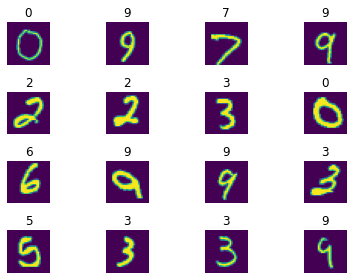

In [6]:
fig, ax = plt.subplots(4, 4)
for i, a in enumerate(ax.flat):
  a.imshow(example[0][i].squeeze())
  a.set_title(example[1][i].item())
  a.set_axis_off()
fig.tight_layout()

In [383]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

def log_categorical(x, p, num_classes=10, reduction=None, dim=None):
    x = x[0].flatten(2, 3)
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_standard_normal(x, reduction=None, dim=None):
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# Source: https://github.com/jornpeters/integer_discrete_flows
class RoundStraightThrough(torch.autograd.Function):
    
    def __init__(self):
        super().__init__()

    @staticmethod
    def forward(ctx, input):
        rounded = torch.round(input, out=None)
        return rounded

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

In [384]:
class Encoder(torch.nn.Module):
    def __init__(self, encoder_net):
        super(Encoder, self).__init__()

        self.encoder = encoder_net

        self.round = RoundStraightThrough.apply

    def reparameterization(self, mu_e, log_var_e):
        std = torch.exp(0.5*log_var_e)
        eps = torch.randn_like(std)
        return mu_e + std * eps

    def encode(self, x):
        x = x[0]
        h_e = self.encoder(x)
        mu_e, log_var_e = torch.chunk(h_e, 2, dim=1)
        return mu_e, log_var_e

    def sample(self, x=None, mu_e=None, log_var_e=None):
        if (mu_e is None) and (log_var_e is None):
            mu_e, log_var_e = self.encode(x)
        else:
            if (mu_e is None) or (log_var_e is None):
                raise ValueError('mu and log-scale can`t be None!')
            z = self.reparameterization(mu_e, log_var_e)
        return z

    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        if x is not None:
            mu_e, log_var_e = self.encode(x)
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        else:
            if (mu_e is None) or (log_var_e is None) or (z is None):
                raise ValueError('mu, log-scale and z can`t be None!')

        return log_normal_diag(z, mu_e, log_var_e)

    def forward(self, x, type='log_prob'):
        assert type in ['encode', 'log_prob'], 'Type could be either encode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x)
        else:
            return self.sample(x)

In [385]:
class Decoder(torch.nn.Module):
    def __init__(self, decoder_net, distribution='categorical', num_vals=None):
        super(Decoder, self).__init__()

        self.decoder = decoder_net
        self.distribution = distribution
        self.num_vals=num_vals

    def decode(self, z):

        h_d = self.decoder(z)

        if self.distribution == 'categorical':
            b = h_d.shape[0]
            d = h_d.shape[1]//self.num_vals
            h_d = h_d.view(b, d, self.num_vals)
            mu_d = torch.softmax(h_d, 1)
            return [mu_d]

        elif self.distribution == 'bernoulli':
            mu_d = torch.sigmoid(h_d)
            return [mu_d]

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

    def sample(self, z):
        outs = self.decode(z)

        if self.distribution == 'categorical':
            mu_d = outs[0]
            b = mu_d.shape[0]
            m = mu_d.shape[1]
            mu_d = mu_d.view(mu_d.shape[0], -1, self.num_vals)
            p = mu_d.view(-1, self.num_vals)
            x_new = torch.multinomial(p, num_samples=1).view(b, m)

        elif self.distribution == 'bernoulli':
            mu_d = outs[0]
            x_new = torch.bernoulli(mu_d)

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

        return x_new

    def log_prob(self, x, z):
        outs = self.decode(z)

        if self.distribution == 'categorical':
            mu_d = outs[0]
            log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)

        elif self.distribution == 'bernoulli':
            mu_d = outs[0]
            log_p = log_bernoulli(x, mu_d, reduction='sum', dim=-1)

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

        return log_p

    def forward(self, z, x=None, type='log_prob'):
        assert type in ['decoder', 'log_prob'], 'Type could be either decode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x, z)
        else:
            return self.sample(x)

In [386]:
class FlowPrior(torch.nn.Module):
    def __init__(self, nets, nett, num_flows, D=2):
        super(FlowPrior, self).__init__()

        self.D = D

        self.t = torch.nn.ModuleList([nett() for _ in range(num_flows)])
        self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])
        self.num_flows = num_flows

    def coupling(self, x, index, forward=True):
        (xa, xb) = torch.chunk(x, 2, 1)

        s = self.s[index](xa)
        t = self.t[index](xa)

        if forward:
            #yb = f^{-1}(x)
            yb = (xb - t) * torch.exp(-s)
        else:
            #xb = f(y)
            yb = torch.exp(s) * xb + t

        return torch.cat((xa, yb), 1), s

    def permute(self, x):
        return x.flip(1)

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in range(self.num_flows):
            z, s = self.coupling(z, i, forward=True)
            z = self.permute(z)
            log_det_J = log_det_J - s.sum(dim=1)

        return z, log_det_J

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x, _ = self.coupling(x, i, forward=False)

        return x

    def sample(self, batch_size):
        z = torch.randn(batch_size, self.D)
        x = self.f_inv(z)
        return x.view(-1, self.D)

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_p = (log_standard_normal(z) + log_det_J.unsqueeze(1))
        return log_p

In [387]:
class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder, prior, num_vals=256, L=16, likelihood_type='categorical'):
        super(VAE, self).__init__()

        print('VAE by JT.')

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

        self.num_vals = num_vals

        self.likelihood_type = likelihood_type

    def forward(self, x, reduction='avg'):
        # encoder
        mu_e, log_var_e = self.encoder.encode(x[0])
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        # ELBO
        RE = self.decoder.log_prob(x, z)
        KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)

        error = 0
        if np.isnan(RE.detach().numpy()).any():
            print('RE {}'.format(RE))
            error = 1
        if np.isnan(KL.detach().numpy()).any():
            print('RE {}'.format(KL))
            error = 1

        if error == 1:
            raise ValueError()

        if reduction == 'sum':
            return -(RE + KL).sum()
        else:
            return -(RE + KL).mean()

    def sample(self, batch_size=64):
        z = self.prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)

In [434]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch[0].shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader))[0].detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (28, 28))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader))[0].detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (28, 28))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            batch[0].to(device)
            batch[1].to(device)
            if hasattr(model, 'dequantization'):
                if model.dequantization:

                    batch = batch + torch.rand(batch.shape)
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

In [439]:
D = 28*28   # input dimension
L = 8 # number of latents
M = 392  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 5 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [440]:
likelihood_type = 'categorical'

if likelihood_type == 'categorical':
    num_vals = 10
elif likelihood_type == 'bernoulli':
    num_vals = 1

# First, we initialize the encoder and the decoder
# -encoder
encoder_net = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(D, M), torch.nn.LeakyReLU(),
                        torch.nn.Linear(M, M), torch.nn.LeakyReLU(),
                        torch.nn.Linear(M, 2 * L))

encoder = Encoder(encoder_net=encoder_net)

# -decoder
decoder_net = torch.nn.Sequential(torch.nn.Linear(L, M), torch.nn.LeakyReLU(),
                        torch.nn.Linear(M, M), torch.nn.LeakyReLU(),
                        torch.nn.Linear(M, num_vals * D))

decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net, num_vals=num_vals)

num_flows = 3

# scale (s) network
nets = lambda: torch.nn.Sequential(torch.nn.Linear(L // 2, M), torch.nn.LeakyReLU(),
                                torch.nn.Linear(M, M), torch.nn.LeakyReLU(),
                                torch.nn.Linear(M, L // 2), torch.nn.Tanh())

# translation (t) network
nett = lambda: torch.nn.Sequential(torch.nn.Linear(L // 2, M), torch.nn.LeakyReLU(),
                                torch.nn.Linear(M, M), torch.nn.LeakyReLU(),
                                torch.nn.Linear(M, L // 2))

prior = FlowPrior(nets, nett, num_flows=num_flows, D=L)

# Eventually, we initialize the full model
model = VAE(encoder=encoder, decoder=decoder, prior=prior, num_vals=num_vals, L=L, likelihood_type=likelihood_type)
model.to(device)

VAE by JT.


VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=392, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=392, out_features=392, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Linear(in_features=392, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=392, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=392, out_features=392, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=392, out_features=7840, bias=True)
    )
  )
  (prior): FlowPrior(
    (t): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=392, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=392, out_features=392, bias=True)
        (3): LeakyReLU(negative_slope=0.01)

In [441]:
# OPTIMIZER
#optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [443]:
prior_name = 'realnvp'
num_components = 1

name = 'vae_' + prior_name + '_' + str(num_components) + '_' + str(L)
result_dir ='results/' + name + '/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer, training_loader=trainloader, val_loader=valloader)

Epoch: 0, val nll=5136.876375
saved!
Epoch: 1, val nll=5136.631496875
saved!
Epoch: 2, val nll=5136.80277265625
Epoch: 3, val nll=5136.69813828125
Epoch: 4, val nll=5136.9253765625


FINAL LOSS: nll=5219.141596875


IndexError: ignored

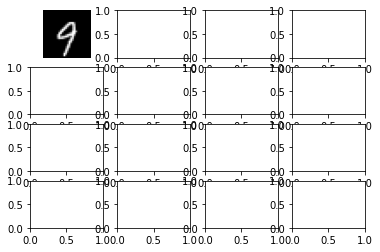

In [423]:
test_loss = evaluation(name=result_dir + name, test_loader=testloader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, testloader)

plot_curve(result_dir + name, nll_val)

samples_generated(result_dir + name, testloader, extra_name='FINAL')